In [192]:
# Debug weights for bidirectional LSTM model
from lstm.lstm_from_scratch import LSTMModel

# Load preprocessor to get vocabulary size
preprocessor = TextPreprocessor(vocab_size=10000, max_length=100)
train_data = pd.read_csv('../../datasets/train.csv', index_col='id')
X_train_text = train_data['text'].values
y_train = train_data['label'].values

# Build tokenizer and get vocab size
preprocessor.build_tokenizer(X_train_text)
vocab_size = len(preprocessor.tokenizer.word_index) + 1  # +1 for padding token

print(f"Vocabulary size: {vocab_size}")

# Create scratch model
scratch_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_sizes=[64],  # List of hidden sizes
    num_classes=5,
    bidirectional=True
)

# Use the print_all_weights function
model_path = '../../models/lstm_bidirectional.h5'
print(f"\n=== DEBUGGING WEIGHTS FOR {model_path} ===")
scratch_model.print_all_weights(model_path)

Vocabulary size: 2796

=== DEBUGGING WEIGHTS FOR ../../models/lstm_bidirectional.h5 ===

=== ALL WEIGHTS FROM ../../models/lstm_bidirectional.h5 ===
Model layers: 6

--- Layer 0: embedding (Embedding) ---
Number of weight arrays: 1
  Weight 0: shape (2796, 128)
    Sample values: [-0.02313498 -0.06138931 -0.11256029 -0.06784827 -0.06897876 -0.19387175
  0.05510562  0.08682446 -0.05195138 -0.07709547]
    Min: -0.194483, Max: 0.224092, Mean: -0.000091

--- Layer 1: bidirectional_lstm_0 (Bidirectional) ---
Number of weight arrays: 6
  Weight 0: shape (128, 256)
    Sample values: [ 0.01781652  0.08423506  0.04221379 -0.04702159  0.10425685 -0.08669905
  0.00359304 -0.05350222 -0.06056068  0.02735259]
    Min: -0.213330, Max: 0.204216, Mean: 0.000039
  Weight 1: shape (64, 256)
    Sample values: [ 0.02123182 -0.08854706  0.00031882  0.01687066  0.03211176 -0.05418361
 -0.00410675  0.00099833  0.04781459  0.16883092]
    Min: -0.261116, Max: 0.331142, Mean: 0.000516
  Weight 2: shape (256

<Sequential name=sequential_81, built=True>

In [193]:
# Create scratch model with CORRECT architecture
print("Creating scratch model with correct architecture:")
print("- Vocabulary size: 2796")
print("- Embedding dim: 128 (not 100)")
print("- LSTM layers: 2 (first: 64 units, second: 32 units)")
print("- Output classes: 3 (not 5)")
print("- Bidirectional: True")

scratch_model_correct = LSTMModel(
    vocab_size=2796,
    embedding_dim=128,
    hidden_sizes=[64, 32],  # Two LSTM layers
    num_classes=3,          # 3 classes, not 5
    bidirectional=True
)

# Load weights
model_path = '../../models/lstm_bidirectional.h5'
print(f"\nLoading weights from {model_path}...")
scratch_model_correct.load_keras_weights(model_path)
print("✅ Weights loaded successfully!")

Creating scratch model with correct architecture:
- Vocabulary size: 2796
- Embedding dim: 128 (not 100)
- LSTM layers: 2 (first: 64 units, second: 32 units)
- Output classes: 3 (not 5)
- Bidirectional: True

Loading weights from ../../models/lstm_bidirectional.h5...
Loading bidirectional layer: bidirectional_lstm_0
  Using sublayer access method
  Forward weights: kernel=(128, 256), recurrent=(64, 256), bias=(256,)
  Backward weights: kernel=(128, 256), recurrent=(64, 256), bias=(256,)
Loading bidirectional layer: bidirectional_lstm_1
  Using sublayer access method
  Forward weights: kernel=(128, 128), recurrent=(32, 128), bias=(128,)
  Backward weights: kernel=(128, 128), recurrent=(32, 128), bias=(128,)
Weights loaded from ../../models/lstm_bidirectional.h5
✅ Weights loaded successfully!


In [194]:
# Test with corrected architecture
import tensorflow as tf

# Load Keras model
keras_model = tf.keras.models.load_model('../../models/lstm_bidirectional.h5')

# Prepare test data
X_test_tokens = preprocessor.encode_texts_tokenizer(test['text'].values[:5])
print(f"Test input shape: {X_test_tokens.shape}")

# Keras predictions
keras_probs = keras_model.predict(X_test_tokens, verbose=0)
keras_preds = np.argmax(keras_probs, axis=1)
print(f"Keras probabilities shape: {keras_probs.shape}")

# Scratch predictions
scratch_probs = scratch_model_correct.predict_proba(X_test_tokens)
print(f"Scratch probabilities shape: {scratch_probs.shape}")
print(f"Scratch probabilities type: {type(scratch_probs)}")

# Check if scratch_probs is 1D or 2D
if len(scratch_probs.shape) == 1:
    print("ERROR: Scratch model returned 1D array instead of 2D")
    print(f"Scratch probabilities: {scratch_probs}")
elif len(scratch_probs.shape) == 2:
    scratch_preds = np.argmax(scratch_probs, axis=1)
    
    print(f"\nKeras predictions:   {keras_preds}")
    print(f"Scratch predictions: {scratch_preds}")
    print(f"Predictions match: {np.array_equal(keras_preds, scratch_preds)}")

    print(f"\nKeras probabilities (first sample):")
    print(keras_probs[0])
    print(f"Scratch probabilities (first sample):")
    print(scratch_probs[0])

    print(f"\nMaximum probability difference: {np.max(np.abs(keras_probs - scratch_probs))}")
    print(f"Average probability difference: {np.mean(np.abs(keras_probs - scratch_probs))}")

    # Test agreement percentage
    agreement = np.sum(keras_preds == scratch_preds) / len(keras_preds)
    print(f"\nPrediction agreement: {agreement:.4f} ({agreement*100:.1f}%)")
else:
    print(f"ERROR: Unexpected shape for scratch probabilities: {scratch_probs.shape}")

Test input shape: (5, 100)
Keras probabilities shape: (5, 3)
Scratch probabilities shape: (5, 3)
Scratch probabilities type: <class 'numpy.ndarray'>

Keras predictions:   [2 1 0 2 0]
Scratch predictions: [0 1 0 1 1]
Predictions match: False

Keras probabilities (first sample):
[0.00968416 0.00609679 0.984219  ]
Scratch probabilities (first sample):
[0.78224692 0.15033454 0.06741854]

Maximum probability difference: 0.9587682118713001
Average probability difference: 0.3327445667152308

Prediction agreement: 0.4000 (40.0%)


In [195]:
# Debug intermediate outputs for first test sample
print("=== DEBUGGING INTERMEDIATE OUTPUTS ===")

# Get just first sample
single_input = X_test_tokens[0:1]  # Shape (1, 100)
print(f"Single input shape: {single_input.shape}")

# Keras intermediate outputs
print("\n--- KERAS MODEL LAYERS ---")
for i, layer in enumerate(keras_model.layers):
    print(f"Layer {i}: {layer.name} ({type(layer).__name__})")

# Get intermediate outputs from Keras
embedding_layer = keras_model.get_layer('embedding')
keras_embedding_output = embedding_layer(single_input)
print(f"\nKeras embedding output shape: {keras_embedding_output.shape}")
print(f"Keras embedding sample (first 5 dims): {keras_embedding_output[0, 0, :5]}")

# Scratch intermediate outputs  
scratch_embedding_output = scratch_model_correct.embedding.forward(single_input)
print(f"Scratch embedding output shape: {scratch_embedding_output.shape}")
print(f"Scratch embedding sample (first 5 dims): {scratch_embedding_output[0, 0, :5]}")

# Check embedding difference
embedding_diff = np.max(np.abs(keras_embedding_output.numpy() - scratch_embedding_output))
print(f"Max embedding difference: {embedding_diff}")

if embedding_diff < 1e-6:
    print("✅ Embeddings match perfectly!")
else:
    print("❌ Embeddings differ - this might be the source of the problem")

# The issue might be in the bidirectional LSTM weight arrangement
print(f"\n=== SUMMARY ===")
print(f"Current status: Bidirectional weights loaded but predictions differ")
print(f"Next steps: The weight printing above shows the exact weight structure")
print(f"Check if the weight mapping in load_keras_weights() matches the Keras structure")

=== DEBUGGING INTERMEDIATE OUTPUTS ===
Single input shape: (1, 100)

--- KERAS MODEL LAYERS ---
Layer 0: embedding (Embedding)
Layer 1: bidirectional_lstm_0 (Bidirectional)
Layer 2: dropout_0 (Dropout)
Layer 3: bidirectional_lstm_1 (Bidirectional)
Layer 4: dropout_1 (Dropout)
Layer 5: dense_output (Dense)

Keras embedding output shape: (1, 100, 128)
Keras embedding sample (first 5 dims): [-0.00871006 -0.00778702  0.01652241  0.058761    0.06377366]
Scratch embedding output shape: (1, 100, 128)
Scratch embedding sample (first 5 dims): [-0.00871006 -0.00778702  0.01652241  0.058761    0.06377366]
Max embedding difference: 0.0
✅ Embeddings match perfectly!

=== SUMMARY ===
Current status: Bidirectional weights loaded but predictions differ
Next steps: The weight printing above shows the exact weight structure
Check if the weight mapping in load_keras_weights() matches the Keras structure


## Import necessary libraries

In [196]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from sklearn.metrics import f1_score

sys.path.append('../../src')
from lstm.lstm_from_scratch import LSTMModel
from utils.data_preprocessing import TextPreprocessor
from lstm.model_training import create_keras_lstm

import warnings
warnings.filterwarnings("ignore")

In [197]:
# Restart kernel to reload modules
import importlib
import sys

# Remove the module from cache if it exists
if 'lstm.lstm_from_scratch' in sys.modules:
    del sys.modules['lstm.lstm_from_scratch']

# Re-import
sys.path.append('../../src')
from lstm.lstm_from_scratch import LSTMModel
from utils.data_preprocessing import TextPreprocessor
from lstm.model_training import create_keras_lstm

print("Modules reloaded successfully")

Modules reloaded successfully


In [198]:
train = pd.read_csv('../../datasets/train.csv', index_col='id')
valid = pd.read_csv('../../datasets/valid.csv', index_col='id')
test = pd.read_csv('../../datasets/test.csv', index_col='id')
train.head()

,text,label
id,,
219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
436,Ibu pernah bekerja di grab indonesia,neutral
394,Paling suka banget makan siang di sini ayam sa...,positive
592,Pelayanan bus DAMRI sangat baik,positive


In [199]:
test.head()

,text,label
id,,
411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
729,"Iya benar, dia sedang jaga warung.",neutral
373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
262,Bertempat di braga city walk yang satu gedung ...,positive
177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 219 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [201]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 411 to 768
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
 1   label   400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


## Preprocessing

In [202]:
preprocessor = TextPreprocessor(vocab_size=10000, max_length=100)
processed_data = preprocessor.preprocess_dataset(train, valid, test, use_vectorizer=False)

train_seq = processed_data['train_sequences']
val_seq = processed_data['val_sequences']
test_seq = processed_data['test_sequences']
train_labels = processed_data['train_labels']
val_labels = processed_data['val_labels']
test_labels = processed_data['test_labels']

vocab_size = processed_data['vocab_size']
num_classes = processed_data['num_classes']

print(f"Vocab size: {vocab_size}")
print(f"Num classes: {num_classes}")
print(f"Sequence shape: {train_seq.shape}")
print(f"Labels distribution: {np.bincount(train_labels)}")

Vocab size: 2796
Num classes: 3
Sequence shape: (500, 100)
Labels distribution: [192 119 189]


## Modelling

In [203]:
configs = {
    # Effect of number of layers (3 variations)
    'lstm_1layer': {'hidden_sizes': [64], 'bidirectional': False},
    'lstm_2layer': {'hidden_sizes': [64, 32], 'bidirectional': False},
    'lstm_3layer': {'hidden_sizes': [64, 32, 16], 'bidirectional': False},
    
    # Effect of number of cells (3 variations)
    'lstm_cells_32': {'hidden_sizes': [32, 32], 'bidirectional': False},
    'lstm_cells_64': {'hidden_sizes': [64, 64], 'bidirectional': False},
    'lstm_cells_128': {'hidden_sizes': [128, 128], 'bidirectional': False},
    
    # Effect of directionality (2 variations)
    'lstm_unidirectional': {'hidden_sizes': [64, 32], 'bidirectional': False},
    'lstm_bidirectional': {'hidden_sizes': [64, 32], 'bidirectional': True}
}

In [204]:
training_results = {}

for name, config in configs.items():
    print(f"\nTraining {name}...")
    
    # Create and train
    model = create_keras_lstm(vocab_size, num_classes, config)
    
    history = model.fit(
        train_seq, train_labels,
        validation_data=(val_seq, val_labels),
        epochs=10, batch_size=32, verbose=1
    )
    
    # Evaluate
    y_pred = np.argmax(model.predict(test_seq), axis=1)
    macro_f1 = f1_score(test_labels, y_pred, average='macro')
    
    # Save
    model.save(f'../../models/{name}.h5')
    
    training_results[name] = {
        'config': config,
        'macro_f1': macro_f1,
        'history': history.history
    }
    
    print(f"✅ {name} - F1: {macro_f1:.4f}")


Training lstm_1layer...
Epoch 1/10


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3957 - loss: 1.0915 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3745 - loss: 1.0662 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3810 - loss: 1.0851 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3959 - loss: 1.0785 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3750 - loss: 1.0823 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3951 - loss: 1.0799 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3866 - loss: 1.0863 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3976 - loss: 1.0752 - val_accuracy: 0.3800 - val_loss: 1.

✅ lstm_1layer - F1: 0.1844

Training lstm_2layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3670 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.0813
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3273 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3845 - loss: 1.0769 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3759 - loss: 1.0791 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3842 - loss: 1.0899 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3706 - loss: 1.0858 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3719 - loss: 1.0813 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accura

✅ lstm_2layer - F1: 0.1844

Training lstm_3layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4005 - loss: 1.0870 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3713 - loss: 1.0796 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3782 - loss: 1.0831 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3320 - loss: 1.0874 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3789 - loss: 1.0729 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4346 - loss: 1.0863 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3462 - loss: 1.0794 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accura

✅ lstm_3layer - F1: 0.1844

Training lstm_cells_32...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3475 - loss: 1.0964 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3511 - loss: 1.0995 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3907 - loss: 1.0865 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3545 - loss: 1.0848 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3687 - loss: 1.0689 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4171 - loss: 1.0712 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3835 - loss: 1.0696 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accu

✅ lstm_cells_32 - F1: 0.1827

Training lstm_cells_64...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.3381 - loss: 1.0920 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3846 - loss: 1.0878 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3930 - loss: 1.0822 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3793 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3782 - loss: 1.0888 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3461 - loss: 1.0791 - val_accuracy: 0.3800 - val_loss: 1.0809
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3852 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - ac

✅ lstm_cells_64 - F1: 0.1844

Training lstm_cells_128...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.3950 - loss: 1.0889 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3788 - loss: 1.0753 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3760 - loss: 1.0775 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3554 - loss: 1.0880 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3930 - loss: 1.0871 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3677 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3673 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - a

✅ lstm_cells_128 - F1: 0.1844

Training lstm_unidirectional...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3699 - loss: 1.0880 - val_accuracy: 0.3800 - val_loss: 1.0878
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3641 - loss: 1.0790 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3840 - loss: 1.0706 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3535 - loss: 1.0934 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4209 - loss: 1.0648 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3844 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3835 - loss: 1.0718 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/st

✅ lstm_unidirectional - F1: 0.1844

Training lstm_bidirectional...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3860 - loss: 1.0792 - val_accuracy: 0.5300 - val_loss: 0.9939
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4893 - loss: 0.9462 - val_accuracy: 0.5100 - val_loss: 0.9423
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5863 - loss: 0.8438 - val_accuracy: 0.5900 - val_loss: 0.8316
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7857 - loss: 0.6197 - val_accuracy: 0.7000 - val_loss: 0.7323
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9070 - loss: 0.3931 - val_accuracy: 0.7700 - val_loss: 0.6431
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9840 - loss: 0.1271 - val_accuracy: 0.7600 - val_loss: 0.8299
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9929 - loss: 0.0522 - val_accuracy: 0.7500 - val_loss: 0.9757
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56m

✅ lstm_bidirectional - F1: 0.6497


## Compare models

In [205]:
def compare_implementations(model_path, config, test_data):
    """Compare Keras vs from scratch"""
    test_X, test_y = test_data
    
    # Load Keras model
    keras_model = tf.keras.models.load_model(model_path)
    
    # Make a dummy evaluation to build metrics and avoid warnings
    keras_model.evaluate(test_X[:1], test_y[:1], verbose=0)
    
    # Create scratch model
    scratch_model = LSTMModel(
        vocab_size=vocab_size,
        embedding_dim=128,
        hidden_sizes=config['hidden_sizes'],
        num_classes=num_classes,
        bidirectional=config['bidirectional']
    )
    
    # Load weights to scratch model
    scratch_model.load_keras_weights(model_path)
    
    # Get predictions
    keras_proba = keras_model.predict(test_X, verbose=0)
    scratch_proba = scratch_model.predict_proba(test_X)
    
    keras_pred = np.argmax(keras_proba, axis=1)
    scratch_pred = scratch_model.predict(test_X)
    
    # Calculate metrics
    keras_f1 = f1_score(test_y, keras_pred, average='macro')
    scratch_f1 = f1_score(test_y, scratch_pred, average='macro')
    
    max_diff = np.max(np.abs(keras_proba - scratch_proba))
    agreement = np.mean(keras_pred == scratch_pred)
    
    
    return {
        'keras_f1': keras_f1,
        'scratch_f1': scratch_f1,
        'max_diff': max_diff,
        'agreement': agreement
    }

In [206]:
test_data = (test_seq, test_labels)
comparison_results = {}

for name, config in configs.items():
    print(f"\nComparing {name}...")
    model_path = f'../../models/{name}.h5'
    
    result = compare_implementations(model_path, config, test_data)
    comparison_results[name] = result
    
    print(f"  Keras F1: {result['keras_f1']:.4f}")
    print(f"  Scratch F1: {result['scratch_f1']:.4f}")
    print(f"  Max diff: {result['max_diff']:.6f}")
    print(f"  Agreement: {result['agreement']:.4f}")


Comparing lstm_1layer...


Weights loaded from ../../models/lstm_1layer.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_2layer...


Weights loaded from ../../models/lstm_2layer.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_3layer...


Weights loaded from ../../models/lstm_3layer.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_32...


Weights loaded from ../../models/lstm_cells_32.h5


  Keras F1: 0.1827
  Scratch F1: 0.1827
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_64...


Weights loaded from ../../models/lstm_cells_64.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_cells_128...


Weights loaded from ../../models/lstm_cells_128.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_unidirectional...


Weights loaded from ../../models/lstm_unidirectional.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing lstm_bidirectional...


Loading bidirectional layer: bidirectional_lstm_0
  Using sublayer access method
  Forward weights: kernel=(128, 256), recurrent=(64, 256), bias=(256,)
  Backward weights: kernel=(128, 256), recurrent=(64, 256), bias=(256,)
Loading bidirectional layer: bidirectional_lstm_1
  Using sublayer access method
  Forward weights: kernel=(128, 128), recurrent=(32, 128), bias=(128,)
  Backward weights: kernel=(128, 128), recurrent=(32, 128), bias=(128,)
Weights loaded from ../../models/lstm_bidirectional.h5
  Keras F1: 0.6497
  Scratch F1: 0.3594
  Max diff: 0.897698
  Agreement: 0.6025


## Analysis and Visualization

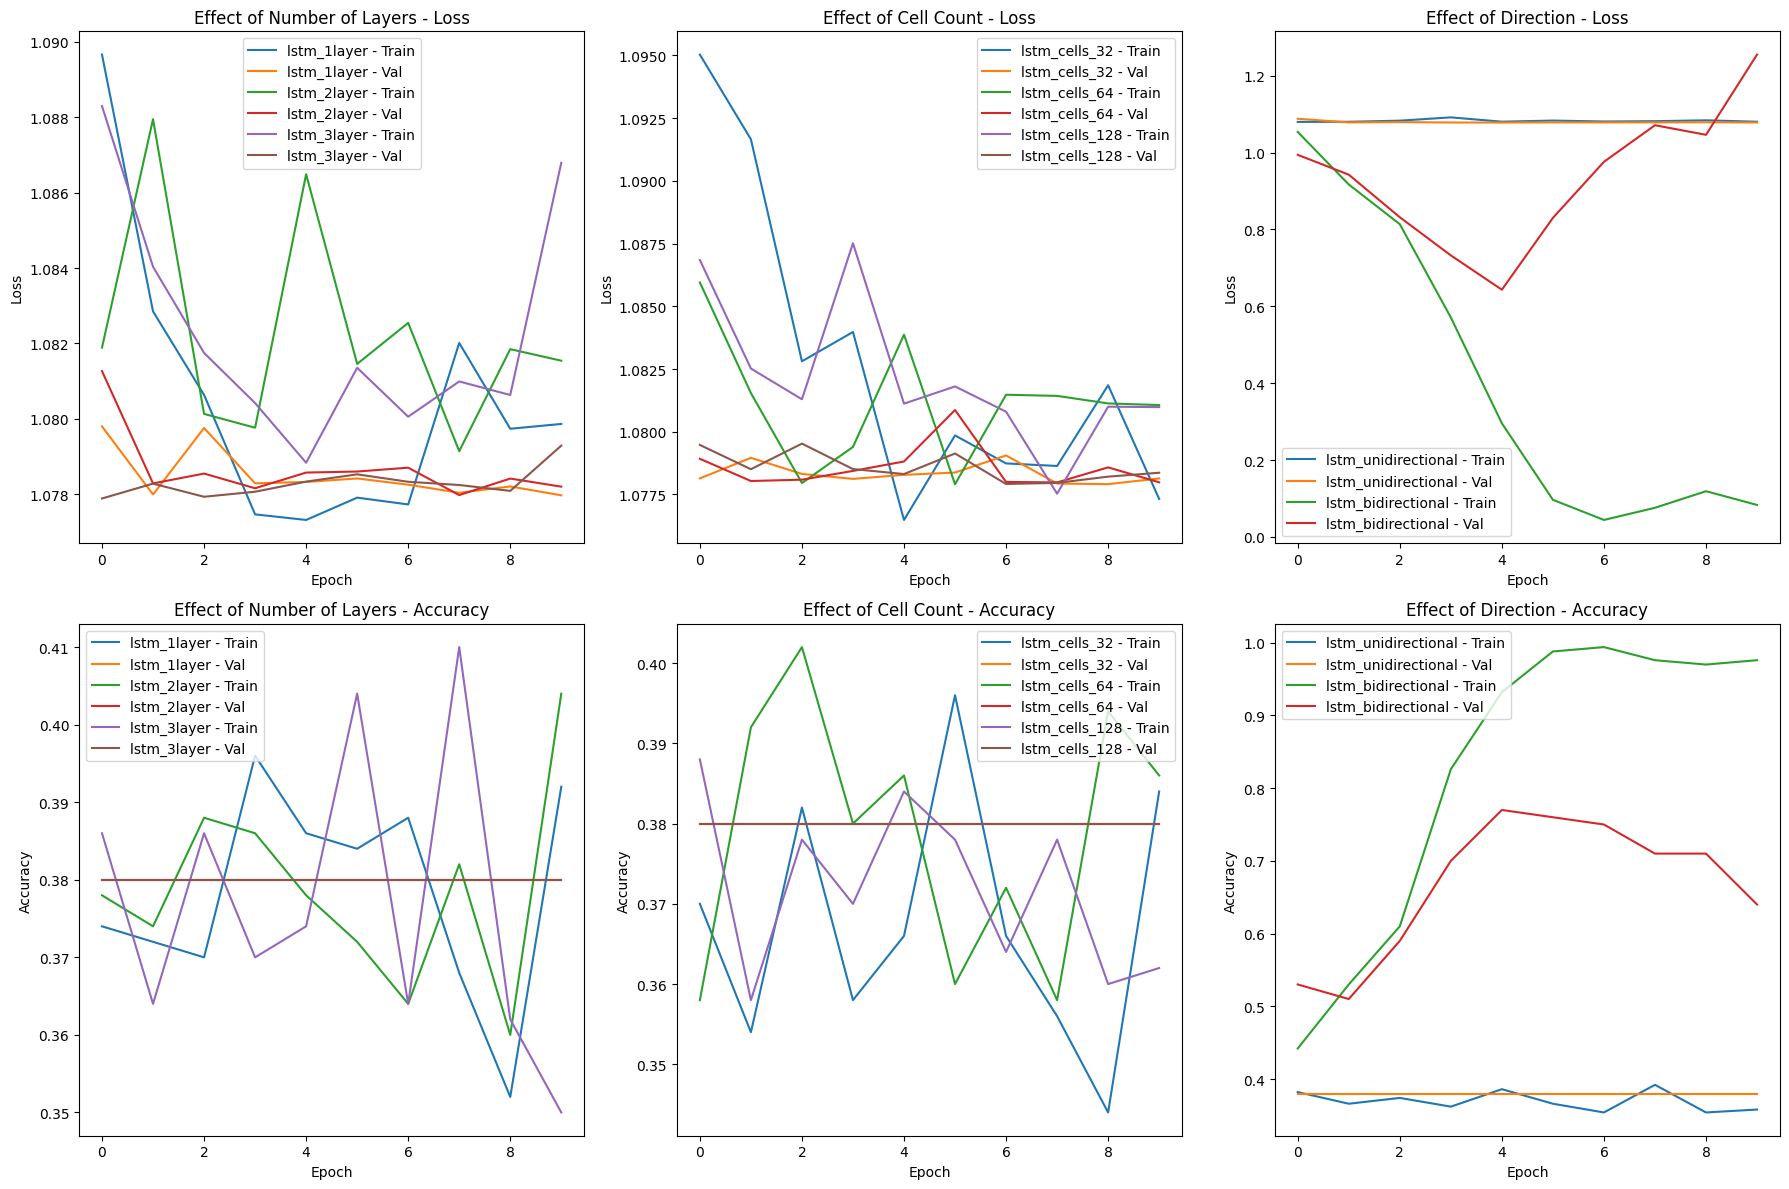

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(training_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    layer_configs = ['lstm_1layer', 'lstm_2layer', 'lstm_3layer']
    for i, config in enumerate(layer_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 0].plot(history['loss'], label=f'{config} - Train')
            axes[0, 0].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 0].set_title('Effect of Number of Layers - Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            
            # Accuracy plot
            axes[1, 0].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 0].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 0].set_title('Effect of Number of Layers - Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
    
    # Cell variations
    cell_configs = ['lstm_cells_32', 'lstm_cells_64', 'lstm_cells_128']
    for i, config in enumerate(cell_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 1].plot(history['loss'], label=f'{config} - Train')
            axes[0, 1].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 1].set_title('Effect of Cell Count - Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            
            # Accuracy plot
            axes[1, 1].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 1].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 1].set_title('Effect of Cell Count - Accuracy')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].legend()
    
    # Direction variations
    direction_configs = ['lstm_unidirectional', 'lstm_bidirectional']
    for i, config in enumerate(direction_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 2].plot(history['loss'], label=f'{config} - Train')
            axes[0, 2].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 2].set_title('Effect of Direction - Loss')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Loss')
            axes[0, 2].legend()
            
            # Accuracy plot
            axes[1, 2].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 2].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 2].set_title('Effect of Direction - Accuracy')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Accuracy')
            axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(training_results)